###AI In Industry Project
####team members:
#####Parsa Mastouri Kashani
#####Freddy Fernandes
#####Arina Sadeghi Khiabanian

# Anomaly Detection - ECG
- Finding anomalous electrocardiograms (ECG).
- using the ECG5000 dataset found [here](http://timeseriesclassification.com/description.php?Dataset=ECG5000).
-Model: LSTM Autoencoder

In [1]:
!nvidia-smi

Tue Mar 19 14:16:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#Downloads the ECG5000 dataset
!gdown https://www.timeseriesclassification.com/aeon-toolkit/ECG5000.zip

Downloading...
From: https://www.timeseriesclassification.com/aeon-toolkit/ECG5000.zip
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:01<00:00, 7.84MB/s]


In [3]:
#Unzipping the dataset
!unzip ECG5000.zip

Archive:  ECG5000.zip
  inflating: ECG5000.txt             
  inflating: ECG5000_TEST.arff       
  inflating: ECG5000_TEST.txt        
  inflating: ECG5000_TRAIN.arff      
  inflating: ECG5000_TRAIN.txt       
  inflating: ECG5000_TEST.ts         
  inflating: ECG5000_TRAIN.ts        


## 1. Data Loading and Preprocessing

In [4]:
from scipy.io.arff import loadarff
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import time
import copy
import shutil
import seaborn as sns
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn, optim
from pathlib import Path
import os
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [38]:
# Define batch size and Epochs
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001

In [9]:
%matplotlib inline
%config InlineBackend.figure_format="retina"

sns.set(style="whitegrid", palette="muted", font_scale=1.2)

plt.rcParams["figure.figsize"] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is {device}")

The device is cuda


In [10]:
#Loads the train and test data from an ARFF file into a Pandas df
with open("ECG5000_TRAIN.arff") as f:
  data, _ = loadarff(f)
  train = pd.DataFrame(data)

with open("ECG5000_TEST.arff") as f:
  data, _ = loadarff(f)
  test = pd.DataFrame(data)

In [11]:
#Combines training and testing data into a single DataFrame and shuffles it
df =train.append(test)
df=df.sample(frac=1.0)

<ipython-input-11-c56543c1faec>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df =train.append(test)


In [12]:
class_names =['Normal','PVC', 'R on T','SP','UB']
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

#decoding the target column for clarity
df['target'] = df['target'].str.decode('utf-8')

df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

In [13]:
#Combining training and test data, and renaming columns
column_names = list(df.columns)

In [14]:
column_names[-1] = "label"
df.columns = column_names
df["label"] = df["label"].astype('int32')

# Shuffling the rows in the dataframe to mix test and training data
df.sample(frac=1)

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,label
3372,0.217902,-0.341224,-0.900725,-1.465726,-2.102594,-2.642998,-2.764680,-2.659491,-2.387522,-1.815479,...,-3.545151,-3.484500,-2.925605,-1.976254,-0.888227,0.201584,0.787262,0.519003,0.383347,2
4060,0.389520,0.268910,-0.164033,-0.529724,-0.775821,-1.106544,-1.302695,-1.337015,-1.163862,-0.887850,...,-0.336190,-0.561106,-0.836633,-1.602721,-2.536150,-3.050140,-3.552475,-3.489886,-2.975763,2
3495,0.987672,-0.113945,-0.958799,-1.763565,-2.476966,-2.820593,-2.813838,-2.591146,-2.209344,-1.819156,...,-2.888520,-3.546329,-3.877169,-3.476538,-2.734531,-1.750811,-0.510141,-0.137577,0.570813,2
1887,-1.049901,-2.445754,-3.014710,-3.655870,-3.922246,-3.707203,-2.949995,-1.990050,-1.593473,-1.312512,...,1.143187,0.614531,-0.083617,-0.529308,-0.833725,-0.858460,-0.675820,-0.166918,-0.878473,1
835,-1.715351,-4.086005,-4.296607,-4.313522,-3.894386,-3.295664,-1.896687,-1.375786,-1.156008,-0.492573,...,1.089687,1.216451,1.364183,1.318189,0.988663,0.879190,1.017700,1.014560,-0.956694,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,-0.965357,-2.186983,-3.129764,-3.712629,-3.934232,-3.816712,-3.436685,-2.844273,-1.695391,-1.504085,...,1.234846,0.787063,0.118237,-0.216120,-0.583647,-0.855419,-0.724017,-0.238385,-0.887972,1
1384,-0.828604,-2.556639,-3.773440,-4.090288,-3.395271,-2.504799,-1.930489,-1.697170,-0.968560,-0.605095,...,1.464067,1.623852,1.990580,2.182814,1.921686,1.431762,1.045131,1.294433,0.874445,1
1417,-1.339232,-3.770532,-4.218463,-4.386535,-4.049760,-3.618357,-2.102680,-1.216682,-1.093406,-0.348714,...,0.989548,1.024289,0.954125,0.930175,0.765949,0.626160,0.899802,0.625823,-1.668585,1
1998,-2.182470,-4.066289,-4.220136,-4.377019,-3.394985,-2.162288,-1.744174,-1.535509,-0.584243,-0.265864,...,1.087737,1.340221,1.174520,1.048647,0.505362,0.214061,0.076343,0.861727,0.218770,1


In [15]:
# unique label counts
print(df["label"].value_counts())
unique_labels = df["label"].unique()

1    2919
2    1767
4     194
3      96
5      24
Name: label, dtype: int64


In [16]:
# Separating the dataset into normal and anomaly datasets based on their labels
normal_data_df = df[df["label"]==1].drop(labels="label", axis=1)
normal_data_df = normal_data_df.reset_index(drop=True)
normal_data_df.head()
print(normal_data_df.shape)

(2919, 140)


We seperate the anomalies

In [17]:
anomaly_data_df = df[df["label"]>1].drop(labels="label", axis=1)
anomaly_data_df = anomaly_data_df.reset_index(drop=True)
anomaly_data_df.head()
print(anomaly_data_df.shape)

(2081, 140)


In [18]:
from sklearn.model_selection import train_test_split
# Splitting the normal dataset for training and validation purposes
training_df, validation_df = train_test_split(normal_data_df, test_size=0.2, random_state=42)
validation_df, test_df = train_test_split(validation_df, test_size=0.4, random_state=42)

In [76]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Define your custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32)
        return sample

# Creating dataset instances for training, validation, testing, and anomalies
training_dataset = CustomDataset(training_df)
validation_dataset = CustomDataset(validation_df)
testing_dataset = CustomDataset(test_df)
anomaly_dataset = CustomDataset(anomaly_data_df)

# Creating DataLoader instances to facilitate batch processing and shuffling
training_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
testing_loader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=True)
anomaly_loader = DataLoader(anomaly_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [84]:
import torch
import torch.nn as nn
import pandas as pd

# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.1)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, input_dim),
            nn.Tanh()
        )

    def forward(self, x):
        # Forward pass through encoder and decoder
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# define the input dimension for the model
input_dim = 140
model = Autoencoder(input_dim).to(device)

In [85]:
from torchsummary import summary

# Assuming your input tensor shape is (batch_size, input_dim)
# If your input tensor shape is different, adjust accordingly
summary(model, (input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          18,048
         LeakyReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
         LeakyReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
         LeakyReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 32]           2,080
         LeakyReLU-8                   [-1, 32]               0
            Linear-9                   [-1, 16]             528
        LeakyReLU-10                   [-1, 16]               0
           Linear-11                   [-1, 32]             544
        LeakyReLU-12                   [-1, 32]               0
           Linear-13                   [-1, 64]           2,112
        LeakyReLU-14                   

In [86]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Define learning rate scheduler
# Decay LR by a factor of 0.1 every 15 epochs
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

In [87]:
def train(model, dataloader, optimizer, criterion, scheduler):
    # Switch model to training mode
    losses = []
    model.train()
    for batch in dataloader:
        # Forward pass
        output = model(batch.to(device)).to(device)
        loss = criterion(output, batch.to(device))

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss
        losses.append(loss.item())
    scheduler.step()
    return np.mean(np.array(losses))

In [88]:
def validation(epoch, val_loss_min_input, model, dataloader, criterion):
    num_batches = len(dataloader)
    losses = []
    # Switch to evaluation mode
    model.eval()
    val_loss = 0
    with torch.no_grad():
      for batch in dataloader:
        # Forward pass
        output = model(batch.to(device)).to(device)
        # Compute validation loss
        val_loss += criterion(output, batch.to(device)).item()

      # Average validation loss
      val_loss /= num_batches
      print(val_loss)

      #outputs, targets = fin_outputs, fin_targets
      print(f"\nValidation loss: {val_loss:>8f}.")
      ## save the model if validation loss has decreased
      if val_loss <= val_loss_min_input:
          #create checkpoint variable and add important data
          if epoch > 0:
              print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(val_loss_min_input, val_loss))
          else: print('Saving model ...')
          # save best model
          torch.save(model.state_dict(), f"emo_model_epoch_{epoch}.pth")
          print("Saved PyTorch Model State to model.pth\n")
          val_loss_min_input = val_loss
      else:
        print('validation loss didn\'t go down -____-')

      return val_loss_min_input, val_loss

In [92]:
# Setting initial minimum validation loss to infinity for comparison
val_loss_min = np.Inf
# Training and validating model
train_losses = []
validation_losses = []
for epoch in range(EPOCHS):
  train_loss = train(model,
        training_loader,
        optimizer,
        criterion,
        scheduler)
  train_losses.extend([train_loss])

  val_loss_min, validation_loss = validation(epoch,
                            val_loss_min,
                            model,
                            validation_loader,
                            criterion,
                            )
  validation_losses.extend([validation_loss])

0.37091147402922314

Validation loss: 0.370911.
Saving model ...
Saved PyTorch Model State to model.pth

0.3666148732105891

Validation loss: 0.366615.
Validation loss decreased (0.37091147 --> 0.36661487).  Saving model ...
Saved PyTorch Model State to model.pth

0.36540181934833527

Validation loss: 0.365402.
Validation loss decreased (0.36661487 --> 0.36540182).  Saving model ...
Saved PyTorch Model State to model.pth

0.36559956272443134

Validation loss: 0.365600.
validation loss didn't go down -____-
0.35900627573331195

Validation loss: 0.359006.
Validation loss decreased (0.36540182 --> 0.35900628).  Saving model ...
Saved PyTorch Model State to model.pth

0.3486792395512263

Validation loss: 0.348679.
Validation loss decreased (0.35900628 --> 0.34867924).  Saving model ...
Saved PyTorch Model State to model.pth

0.34405796229839325

Validation loss: 0.344058.
Validation loss decreased (0.34867924 --> 0.34405796).  Saving model ...
Saved PyTorch Model State to model.pth

0.3417

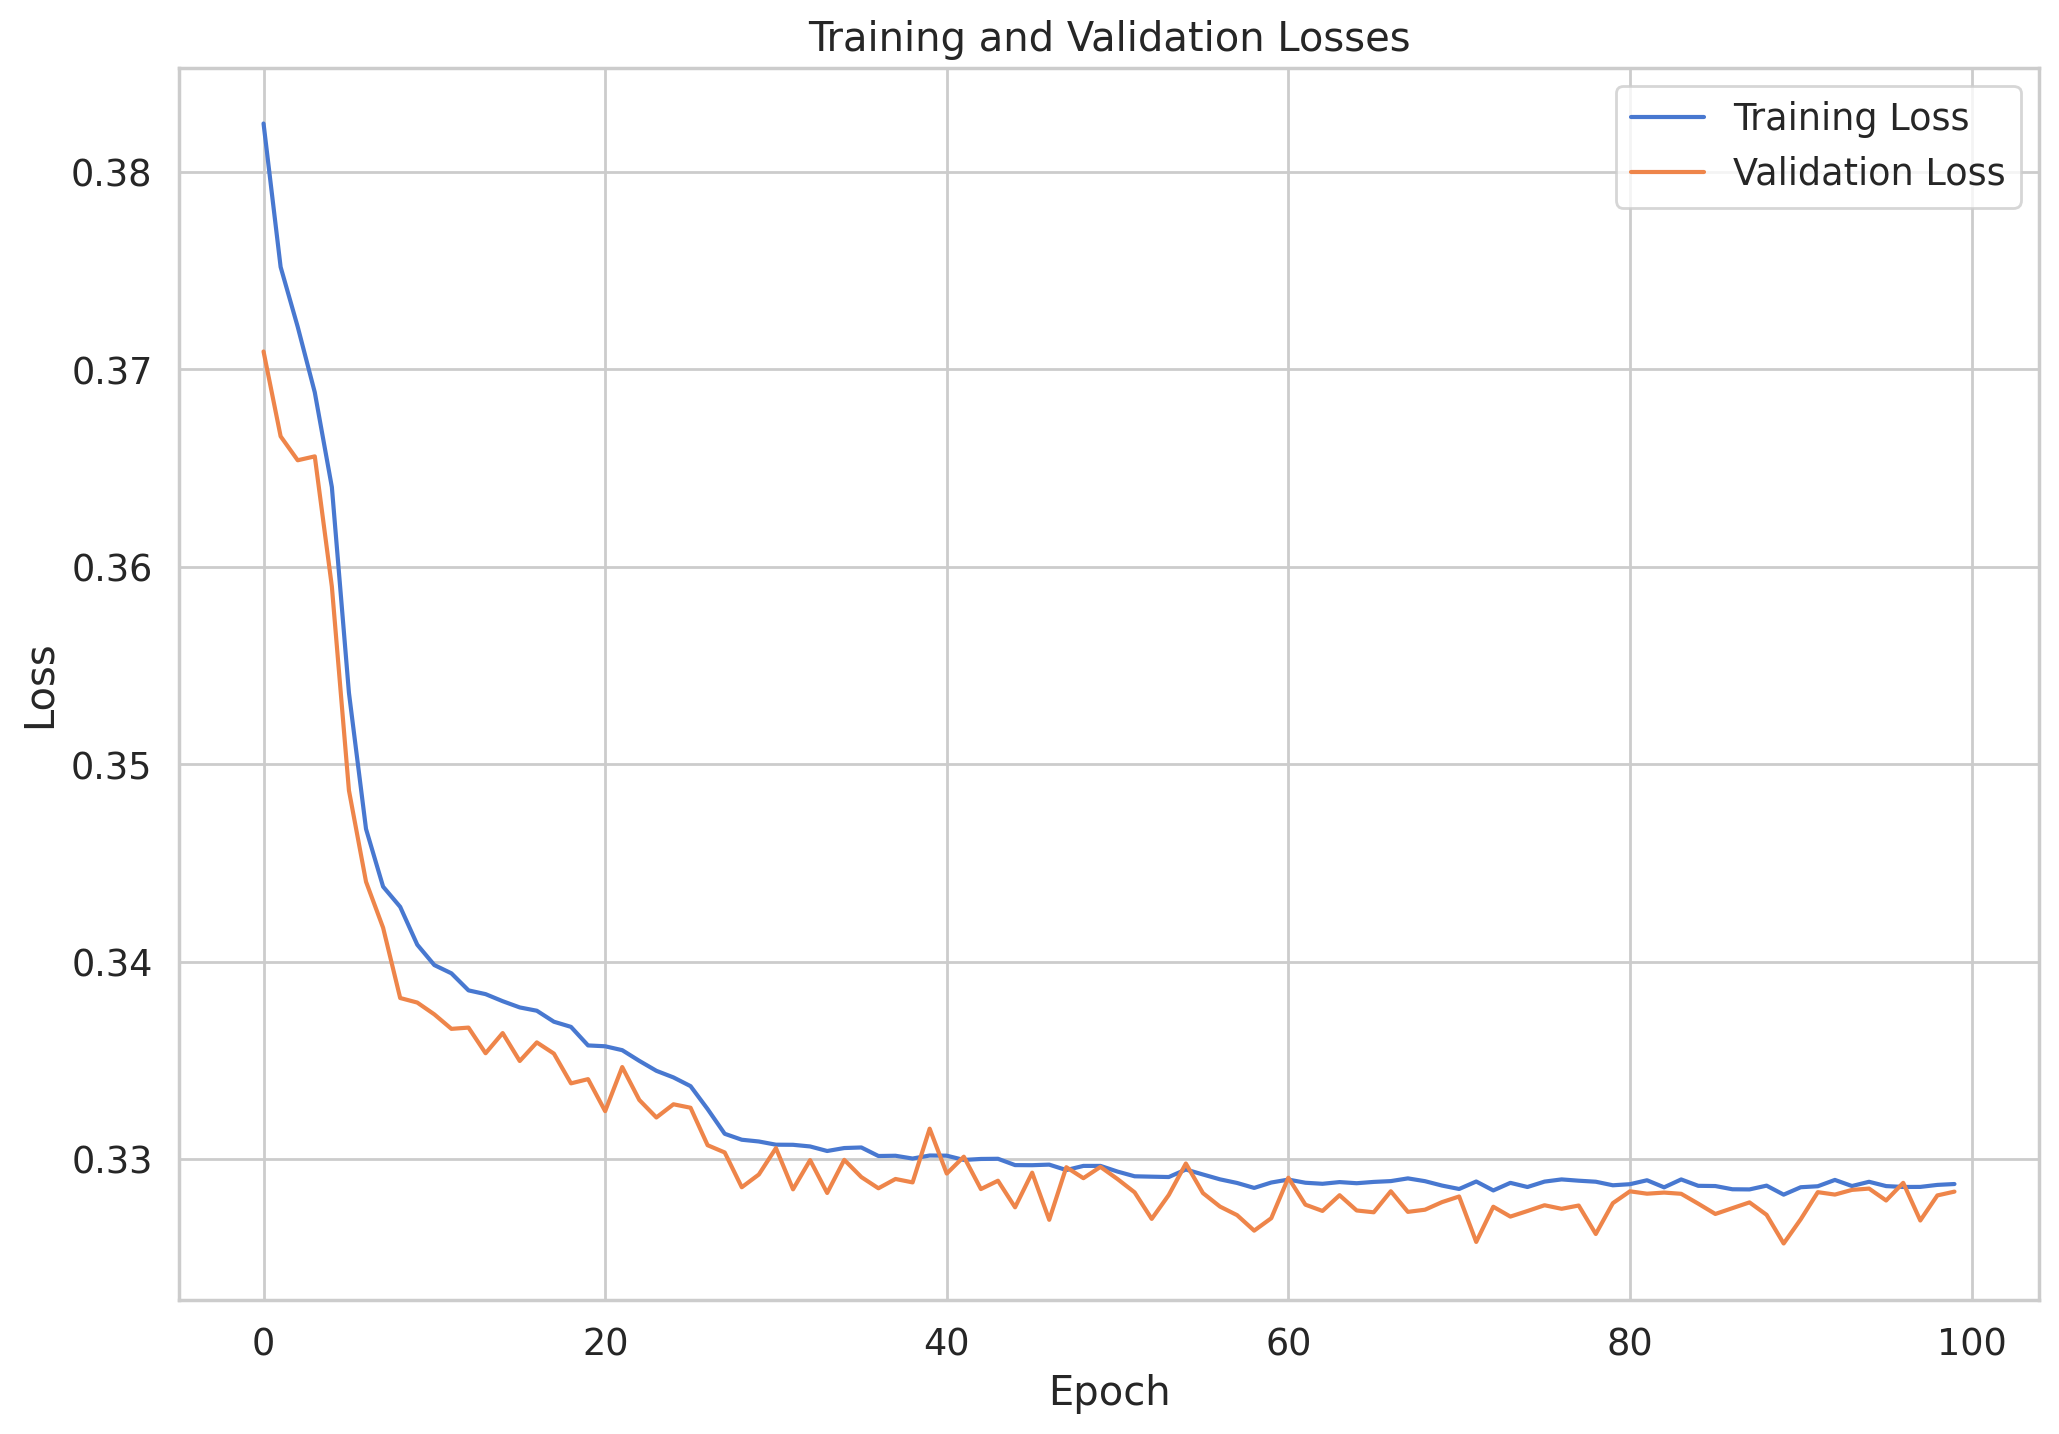

In [93]:
# Plotting
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

Data size:
test_df = 234
anomaly_data_df = 2081


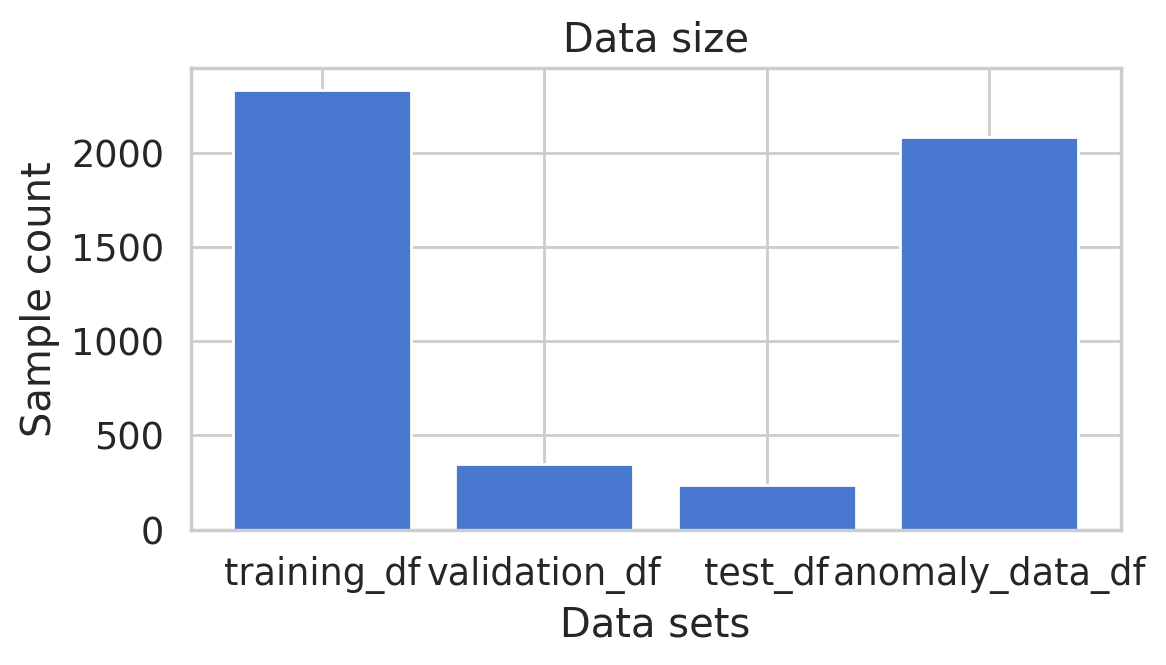

In [53]:
# Visualizing the distribution of data across different datasets
plt.figure(figsize=(6,3))
plt.bar(['training_df', 'validation_df', 'test_df', 'anomaly_data_df'],
        [len(training_df), len(validation_df), len(test_df), len(anomaly_data_df)])

plt.xlabel('Data sets')
plt.ylabel('Sample count')
plt.title('Data size')

print(f'Data size:\ntest_df = {len(test_df)}\nanomaly_data_df = {len(anomaly_data_df)}')
plt.show()

In [54]:
from sklearn.metrics import precision_recall_curve
from tqdm import tqdm

# Computing and displaying key performance indicators for the model

def compute_metrics(model, dataset_normal, dataset_anomaly, device):
    #Evaluates the model's performance by computing precision, recall, and F1 score
    model.eval()

    criterion = nn.L1Loss(reduction='sum').to(device)
    # loss list for normal (n) and anomaly (a) samples
    loss_n, loss_a = [],[]

    # Calculating loss for normal samples
    for batch in tqdm(dataset_normal, desc='Normal samples'):
        for sequence in batch:
          sequence_true = sequence.to(device)
          sequence_pred = model(sequence_true)
          loss = criterion(sequence_pred, sequence_true)
          loss_n.append( sequence.tolist() + [loss.to('cpu').item()] )

    # Calculating loss for anomaly samples
    for batch in tqdm(dataset_anomaly, desc='Anomaly samples'):
        for sequence in batch:
          sequence_true = sequence.to(device)
          sequence_pred = model(sequence_true)
          loss = criterion(sequence_pred, sequence_true)
          loss_a.append( sequence.tolist() + [loss.to('cpu').item()] )

    # Creating a DataFrame to analyze the results
    normal_samples = np.concatenate( ([[0]]*len(loss_n), np.array(loss_n)), axis=1)
    anomaly_samples = np.concatenate( ([[1]]*len(loss_a), np.array(loss_a)), axis=1)
    full_samples = np.concatenate( (normal_samples, anomaly_samples) )
    df_samples = pd.DataFrame(full_samples).rename(columns={0:'label', 141:'loss'})

    # Calculating precision, recall, and F1 score
    precision, recall, thresholds = precision_recall_curve(df_samples['label'], df_samples['loss'])

    # computing the F1 score for each threshold value
    pr, p_r = (precision * recall), (precision + recall)
    f1_scores = [2*(pr/p_r) if p_r > 0 else 0 for pr, p_r in zip(pr, p_r)]

    # find the index of the maximum F1-score
    best_threshold_index = np.argmax(f1_scores)

    # get the best threshold, Precision, Recall values
    best_threshold = thresholds[best_threshold_index]
    best_precision, best_recall = precision[best_threshold_index], recall[best_threshold_index]

    best_metrics = {'Best F1 Score':np.max(f1_scores),
                    'Best threshold':best_threshold,
                    'Best precision':best_precision,
                    'Best recall':best_recall}

    print(best_metrics)

    # Updating DataFrame with predictions
    df_samples['pred'] = np.nan
    pred_normal_idx = df_samples[df_samples.loss < best_threshold].index
    pred_anomaly_idx = df_samples[df_samples.loss >= best_threshold].index
    df_samples.loc[pred_normal_idx, 'pred'] = 0
    df_samples.loc[pred_anomaly_idx, 'pred'] = 1

    # Plotting Precision-Recall curve
    plt.figure(figsize=(4,3))
    plt.plot(recall, precision, color= 'black', label='PR curve')
    plt.scatter(best_recall, best_precision, color='tab:red', label='Best PR - Max F1 Score')

    # setting the plot parms
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Precision-Recall Curve')

    plt.show()

    return df_samples

Anomaly samples: 100%|██████████| 33/33 [00:01<00:00, 18.30it/s]


{'Best F1 Score': 0.992053936913075, 'Best threshold': 46.32479476928711, 'Best precision': 0.9942084942084942, 'Best recall': 0.9899086977414705}


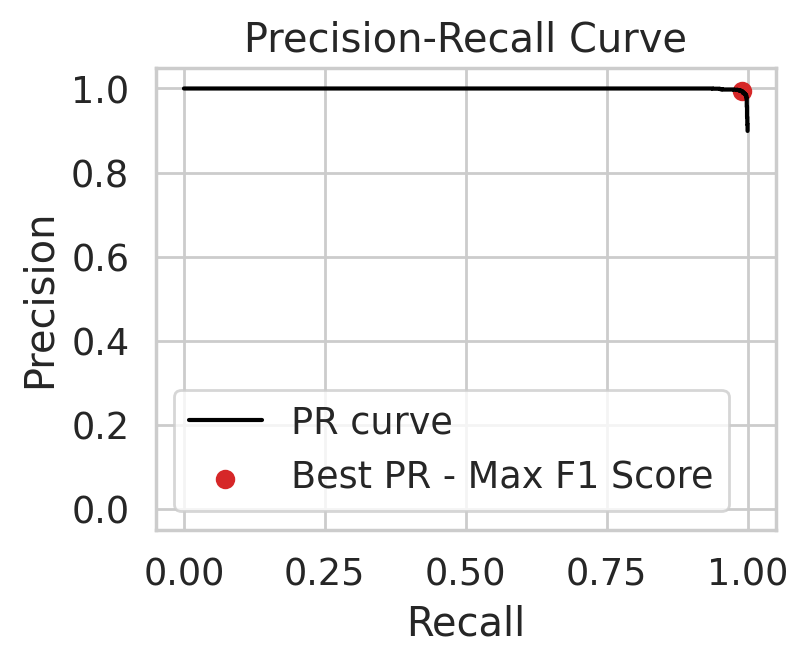

In [55]:
# Evaluating the model and plotting sample predictions
df_samples = compute_metrics(model = model,
                            dataset_normal = testing_loader,
                            dataset_anomaly = anomaly_loader,
                            device = device)

In [56]:
# sampling with fixed seed - normal/anomaly samples
features = np.arange(1, 141)
normal_samples = df_samples[df_samples.label==0].sample(8, random_state=42).astype(np.float32)
normal_samples = torch.tensor(normal_samples[features].values)

anomaly_samples = df_samples[df_samples.label==1].sample(8, random_state=42).astype(np.float32)
anomaly_samples = torch.tensor(anomaly_samples[features].values)

In [57]:
# Plotting actual and predicted samples for visual comparison
def plot_samples(samples, model, title, device='cpu'):
    """ Function that plots the actual samples and the corresponding reconstructions
    Args:
        samples (torch.tensor): samples to plot
        model (torch.nn.Module): model
        title (string): suptitle of the plot
        device (string): device to use - cpu/cuda:0
    """
    samples_pred = []
    criterion = nn.L1Loss(reduction='sum').to(device)
    loss_pred = []

    for i in samples:
        pred = model(i)
        samples_pred.append(pred)
        loss_pred.append(criterion(pred,i))

    samples_pred = torch.stack(samples_pred).tolist()
    samples_truth = samples.tolist()

    #fig, axs = plt.subplots(2, 4, figsize=(14,4.5))
    fig, axs = plt.subplots(2, 4, figsize=(18, 5))
    for ax, p, t, l in zip(axs.flatten(), samples_pred, samples_truth, loss_pred):
        ax.plot(np.arange(0, len(t)), t, color='tab:blue', label='Truth')
        ax.plot(np.arange(0, len(p)), p, color='tab:red', label='Prediction')
        ax.set_title(f'Loss: {round(l.item(), 3)}')
        ax.set_xlabel('Timesteps')
        ax.set_ylabel('Voltage (amplitudes)')
        ax.legend()

    plt.suptitle(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

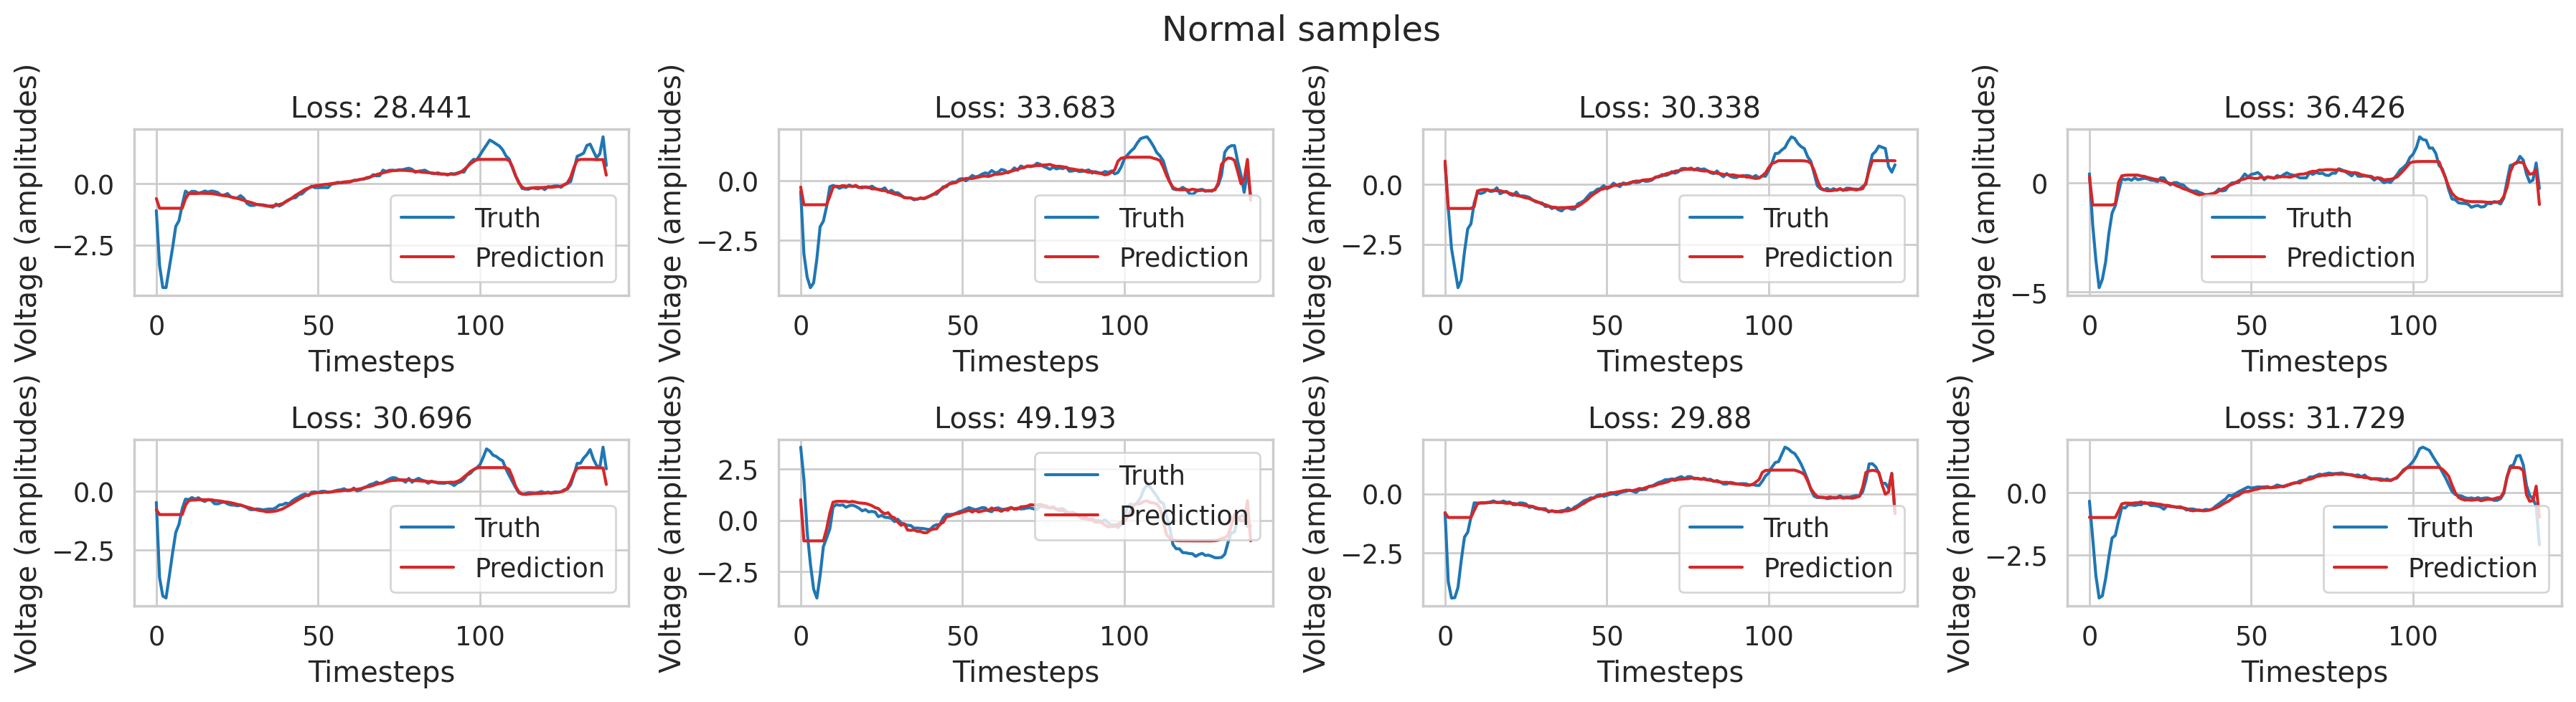

In [58]:
# Displaying plots for normal samples
plot_samples(normal_samples.to(device), model, title='Normal samples')

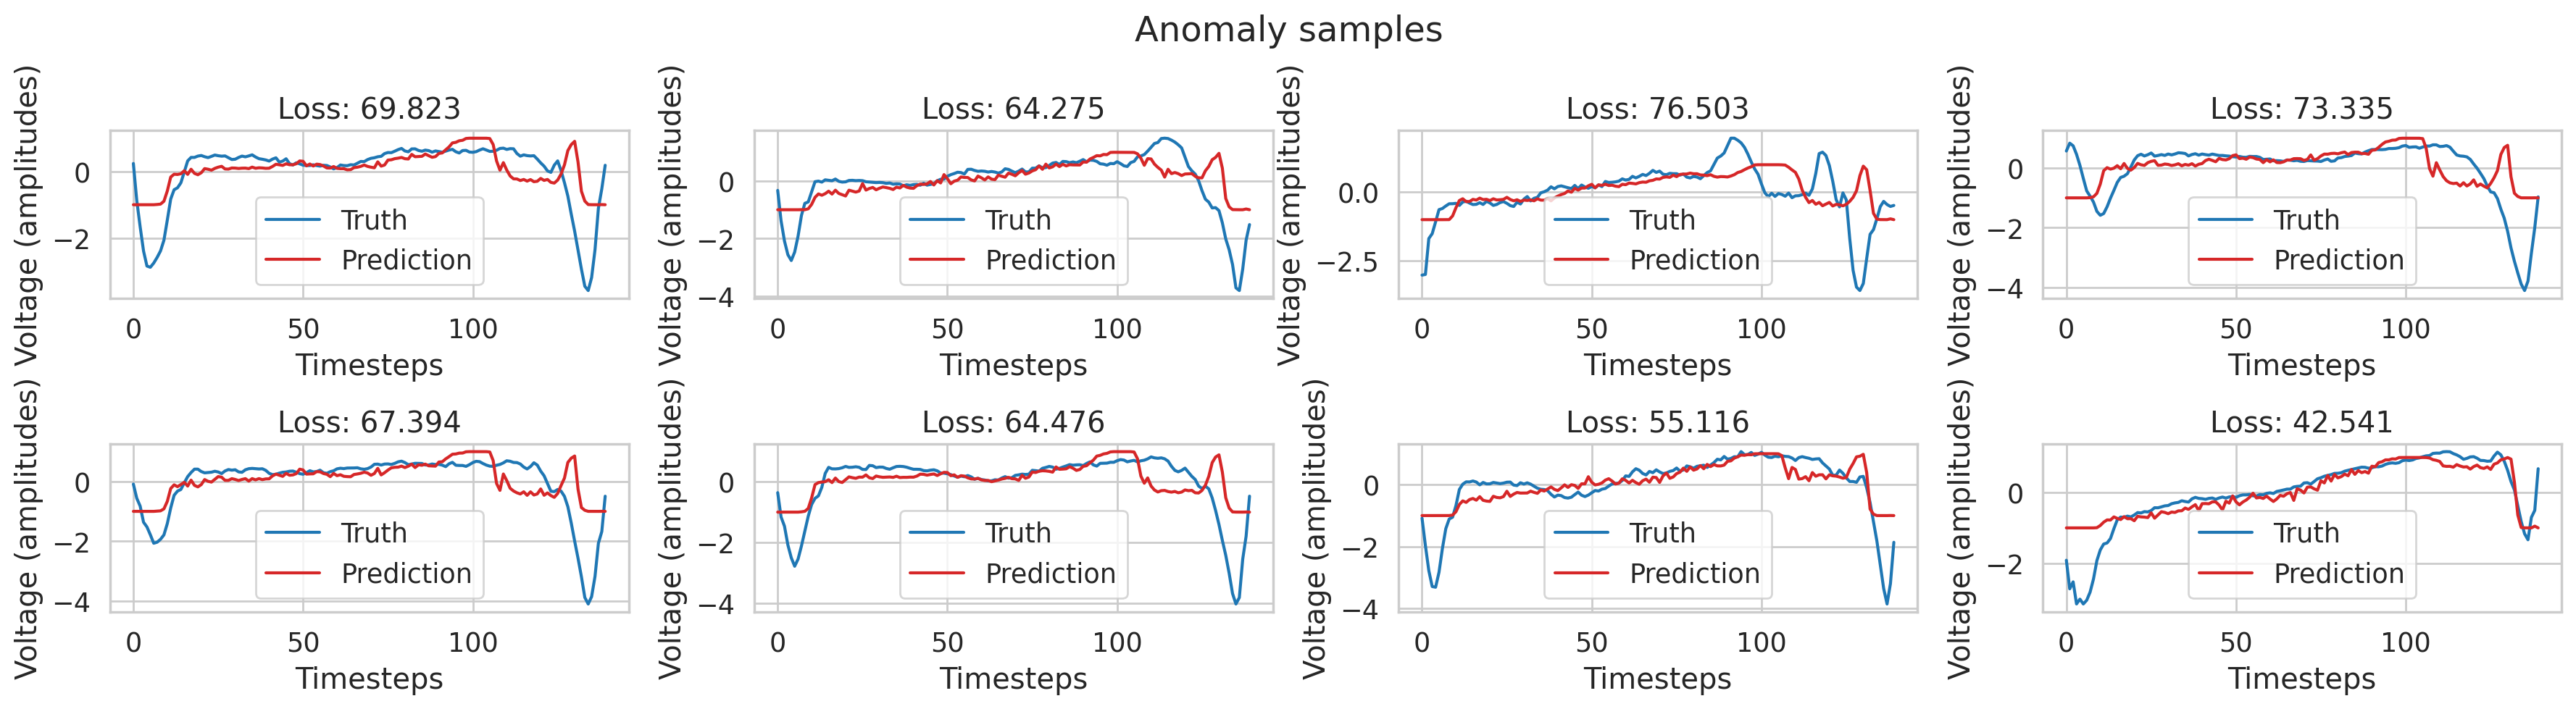

In [59]:
# Displaying plots for anomaly samples
plot_samples(anomaly_samples.to(device), model, title='Anomaly samples')